<a href="https://colab.research.google.com/github/jakubhorvath/VariousMLNotebooks/blob/main/MissingDataManagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Missing data management

### 1. Load in the data

In [ ]:
import pandas as pd
data = pd.read_csv("bodyfat.csv")
data.describe()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.055574,19.150794,44.884921,178.924405,70.148810,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,0.019031,8.368740,12.602040,29.389160,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.995000,0.000000,22.000000,118.500000,29.500000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,1.041400,12.475000,35.750000,159.000000,68.250000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,1.054900,19.200000,43.000000,176.500000,70.000000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,1.070400,25.300000,54.000000,197.000000,72.250000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,1.108900,47.500000,81.000000,363.150000,77.750000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


### 2. Check the feature distribution

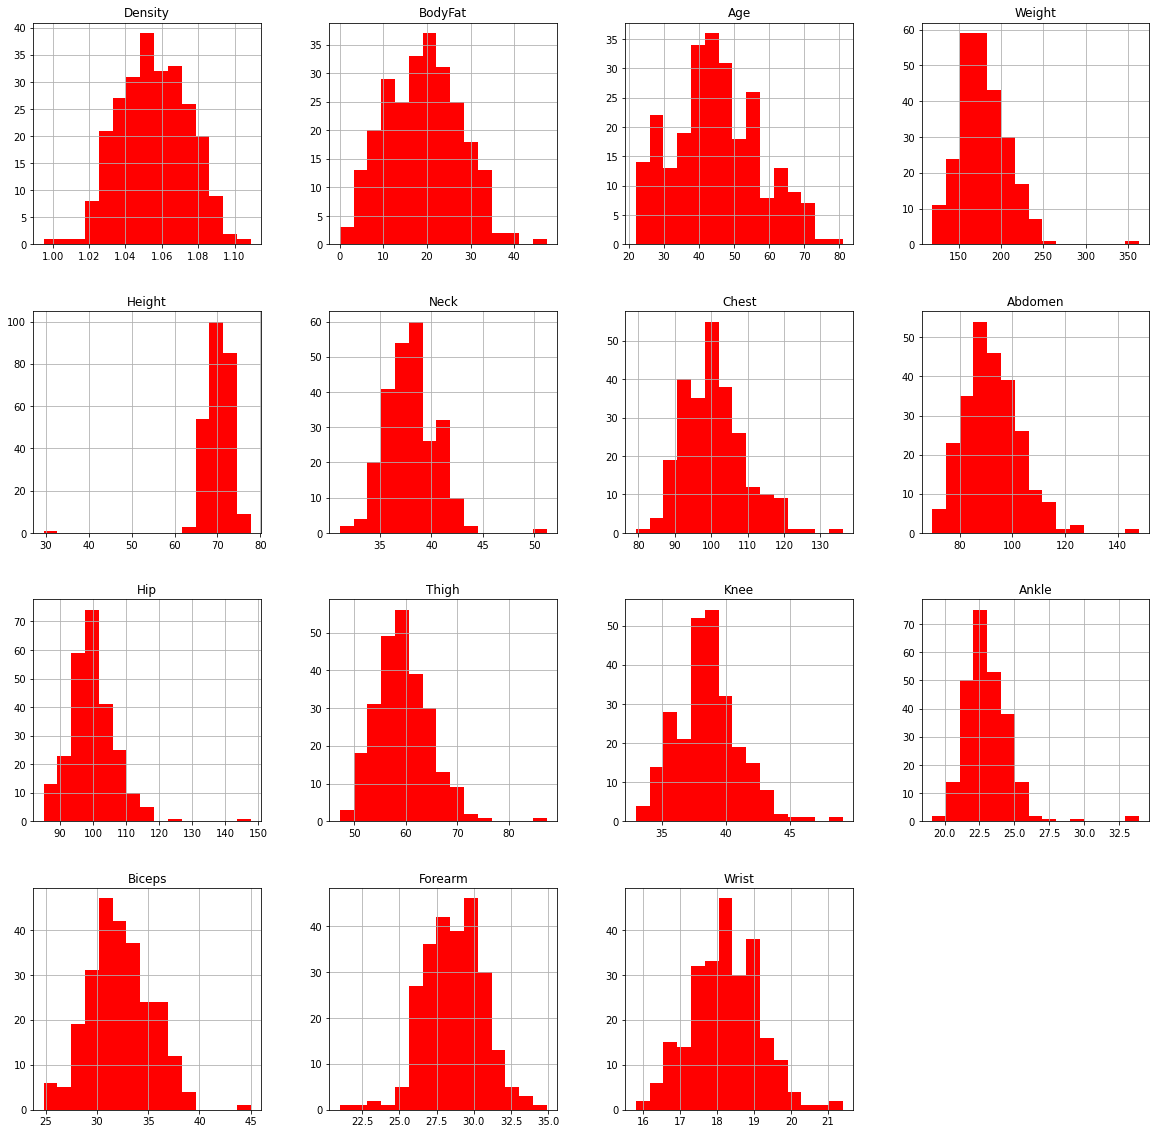

In [ ]:
data.hist(figsize=(20,20),grid=True,color='red',bins=15);

### 3. Inserting missing values
##### - The data is lacking missing values so we artifically insert NaNs to test out the different missing value management methods
##### - We will exclude the BodyFat variable, as this is the predicted variable
##### - The % of values to be inserted and which ones to replace is decided randomly
###### % is within normally distributed with 10 as the mean and 5 as standard deviation, resample until nonnegative value is drawn

In [ ]:
from numpy.random import normal
import random
feature_names = list(data.columns)
feature_names.remove("BodyFat")

data_size = len(data["Density"])

for feature in feature_names:
    # sample from normal distribution with mean 10 and stdev 5
    percentage = int(normal(10, 5, 1)[0])
    # if the sampled value was smaller than 0, resample
    while percentage < 0:
        percentage = normal(10, 5, 1)[0]
    # specify the number of missing values to insert
    n_missing_values = int(data_size*percentage/100)
    # randomly select the positions at which the missing values are inserted
    positions = random.sample(range(0, data_size), n_missing_values)
    column = list(data[feature])
    for position in positions:
        column[position] = None
    data[feature] = column

#### Display how many NaN values have been generated

In [ ]:
data.isna().sum()

Density    40
BodyFat     0
Age        12
Weight     32
Height      5
Neck       25
Chest      20
Abdomen    27
Hip         0
Thigh      27
Knee       27
Ankle      32
Biceps     55
Forearm    25
Wrist      27
dtype: int64

In [ ]:
# create a copy of the data with missing values for future comparison
data_new = data.copy()

### 4. Fixing missing values
#### The approaches tested will be replacing missing values with:
##### - Mean
##### - Median
##### - KNN prediction

In [ ]:
# define a function to replace the target column in a row with regressor prediction
def replace_NAN_by_prediction(regressor, row, target_col):
    if math.isnan(row[target_col]):
        return regressor.predict([row.drop(target_col)])[0]
    else:
        return row[target_col]

In [ ]:
from seaborn import histplot
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import math
import matplotlib.pyplot as plt
def replace_and_plot(data_new, target_column, inplace=False):
    # save the new data into a dataframe for histogram plotting
    df = pd.DataFrame(data_new[target_column])

    # replace missing values with mean and median
    df[f"{target_column}_mean"] = data_new[target_column].replace(to_replace=np.nan, value=data_new[target_column].mean(), inplace=False)
    df[f"{target_column}_median"] = data_new[target_column].replace(to_replace=np.nan, value=data_new[target_column].median(), inplace=False)

    # create a copy of the data to avoid modifying the original
    train_data = pd.DataFrame(data_new.copy())
    feature_columns = list(train_data.columns)
    feature_columns.remove(target_column)

    # temporarily replace all missing values with their mean for the training process
    for column in train_data.columns:
        if column != target_column:
            train_data[column] = train_data[column].replace(to_replace=np.nan, value=train_data[column].mean(),inplace=False)

    # select those rows where the target value isnt missing to train the model
    train = train_data[train_data[target_column].notna()]

    # train a KNN regressor
    KNN = KNeighborsRegressor().fit(train[feature_columns], train[target_column])
    del train

    df[f"{target_column}_KNN"] = train_data.apply(lambda row: replace_NAN_by_prediction(KNN, row, target_column), axis=1)

    # detect the max/min values for scaling the histogram
    max_count = max([df[f"{target_column}_KNN"].value_counts().max(),
                    df[f"{target_column}_mean"].value_counts().max(),
                    df[f"{target_column}_median"].value_counts().max(),
                    df[target_column].value_counts().max()])
    min_value = min([df[f"{target_column}_KNN"].min(),
                    df[f"{target_column}_mean"].min(),
                    df[f"{target_column}_median"].min(),
                    df[target_column].min()])
    max_value = min([df[f"{target_column}_KNN"].max(),
                    df[f"{target_column}_mean"].max(),
                    df[f"{target_column}_median"].max(),
                    df[target_column].max()])
    df.hist(figsize=(10,10),grid=True,color='red', density=True);
"""    for figure in fig:
        for f in figure:
            f.set_xlim((min_value, max_value))
            f.set_ylim((0, max_count+1))"""

'    for figure in fig:\n        for f in figure:\n            f.set_xlim((min_value, max_value))\n            f.set_ylim((0, max_count+1))'

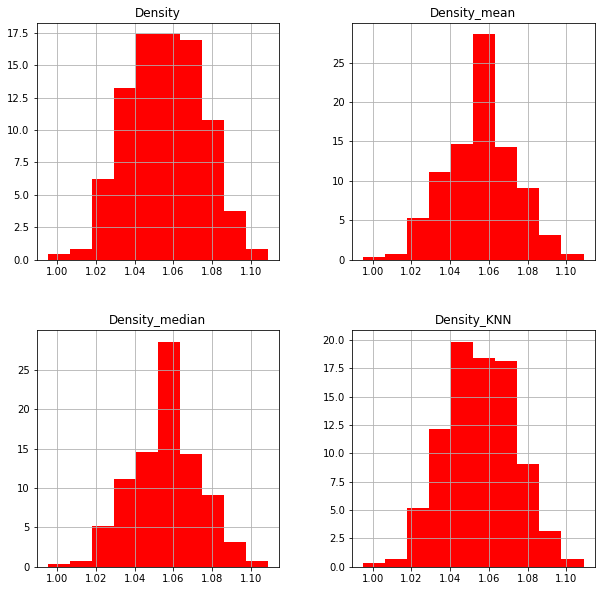

In [ ]:
replace_and_plot(data_new, "Density")

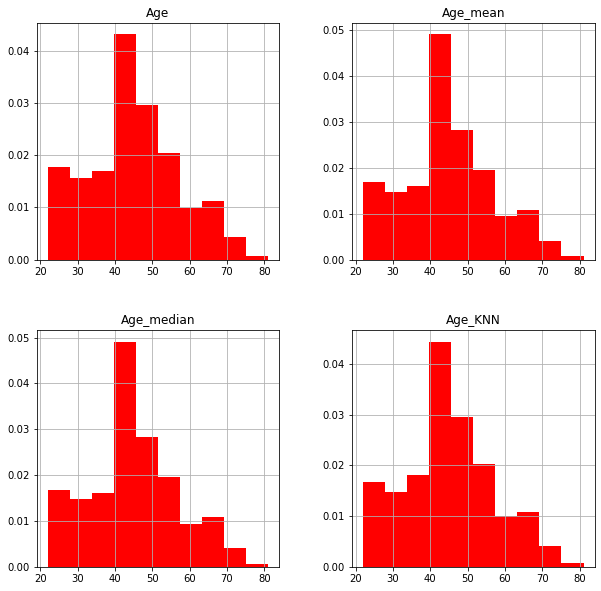

In [ ]:
replace_and_plot(data_new, "Age")

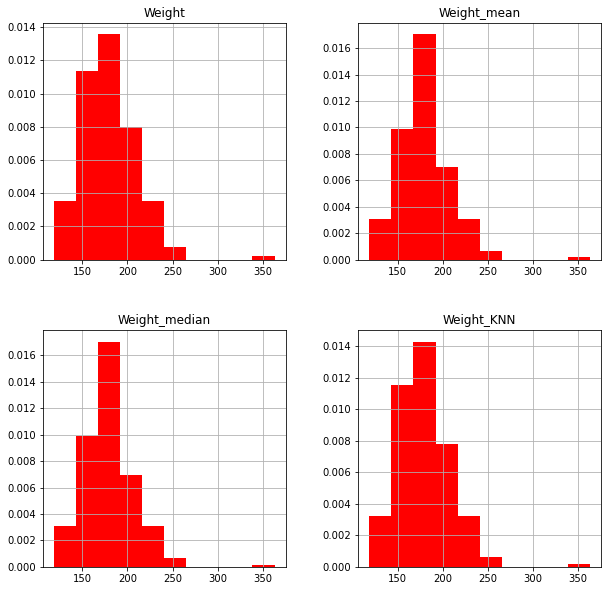

In [ ]:
replace_and_plot(data_new, "Weight")

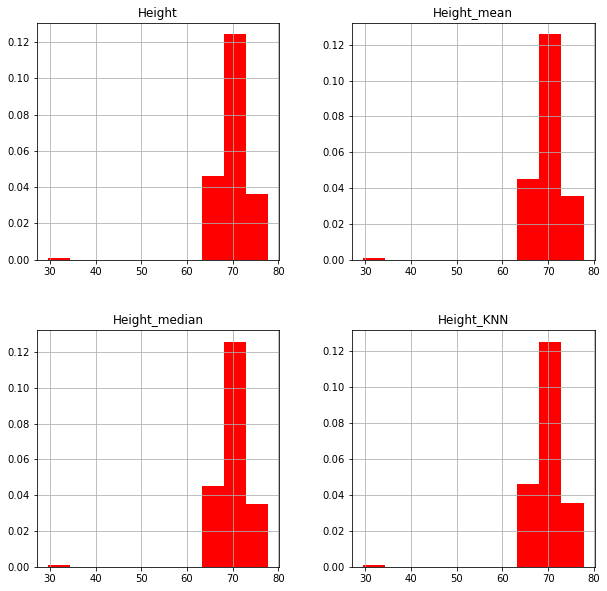

In [ ]:
replace_and_plot(data_new, "Height")

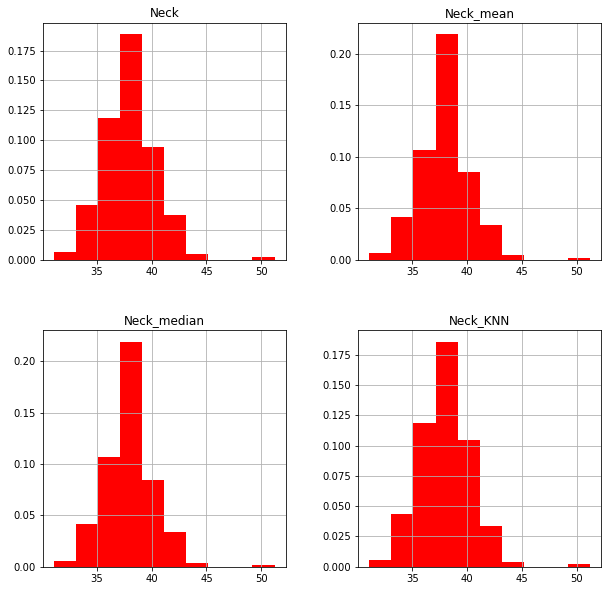

In [ ]:
replace_and_plot(data_new, "Neck")

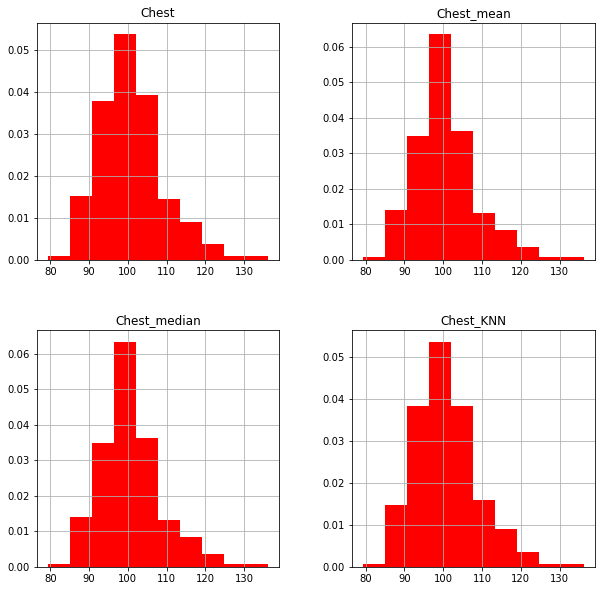

In [ ]:
replace_and_plot(data_new, "Chest")

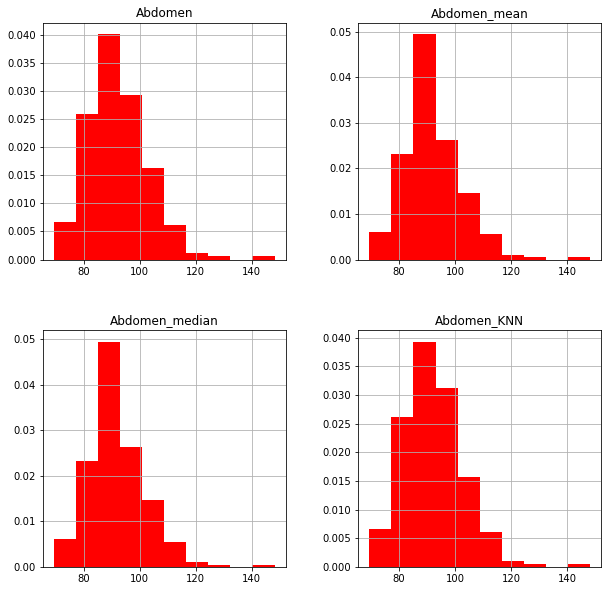

In [ ]:
replace_and_plot(data_new, "Abdomen")

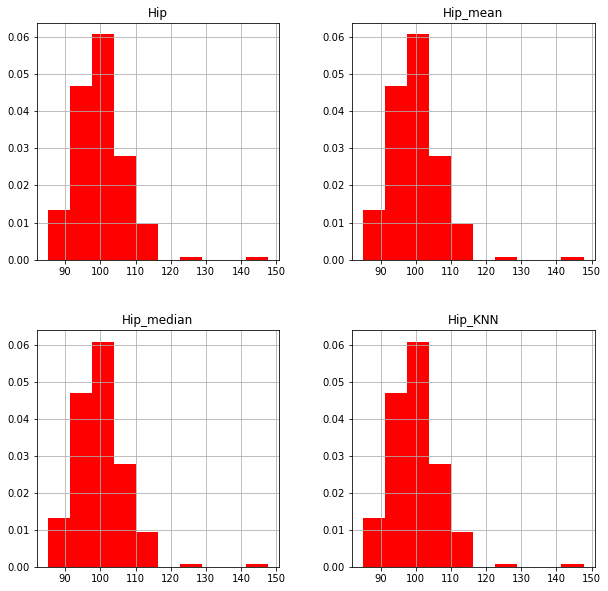

In [ ]:
replace_and_plot(data_new, "Hip")

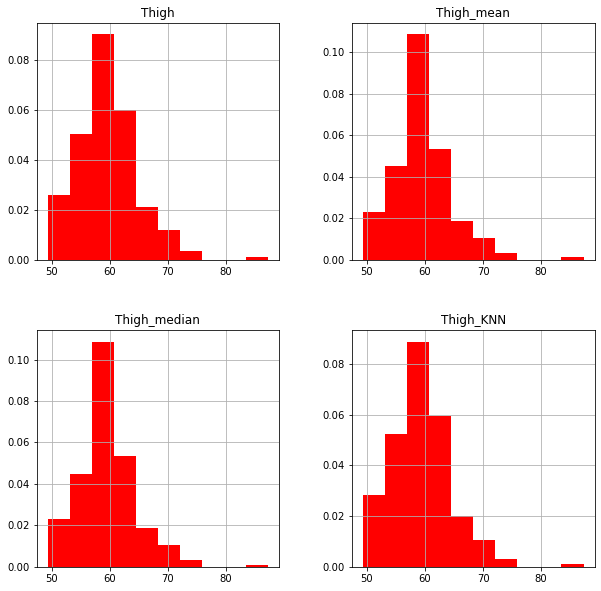

In [ ]:
replace_and_plot(data_new, "Thigh")

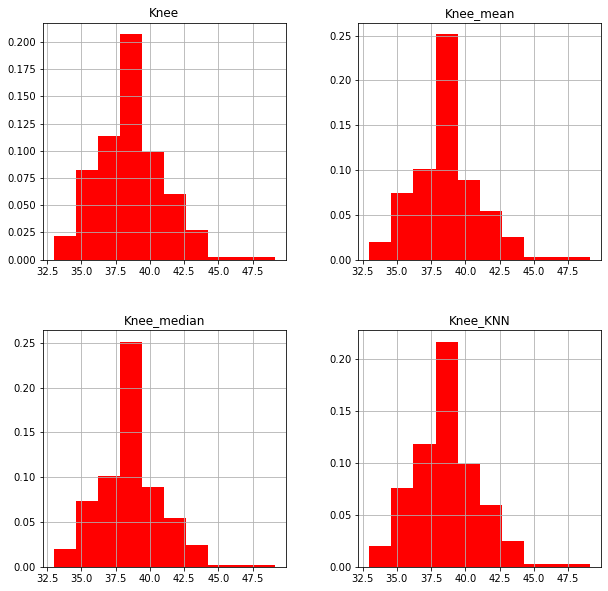

In [ ]:
replace_and_plot(data_new, "Knee")

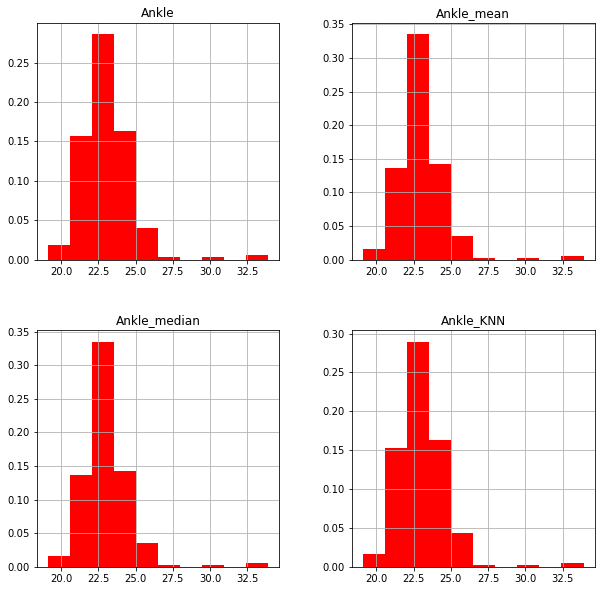

In [ ]:
replace_and_plot(data_new, "Ankle")

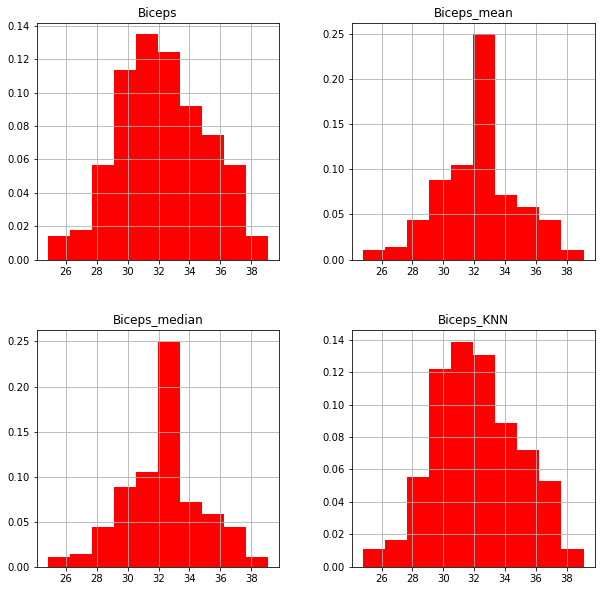

In [ ]:
replace_and_plot(data_new, "Biceps")

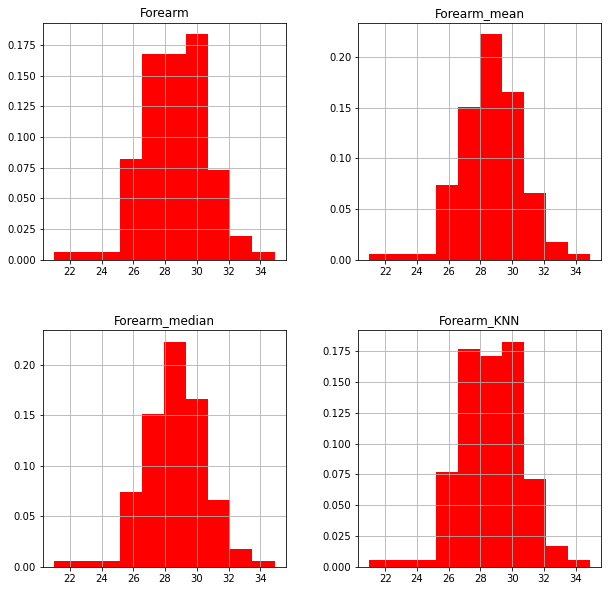

In [ ]:
replace_and_plot(data_new, "Forearm")

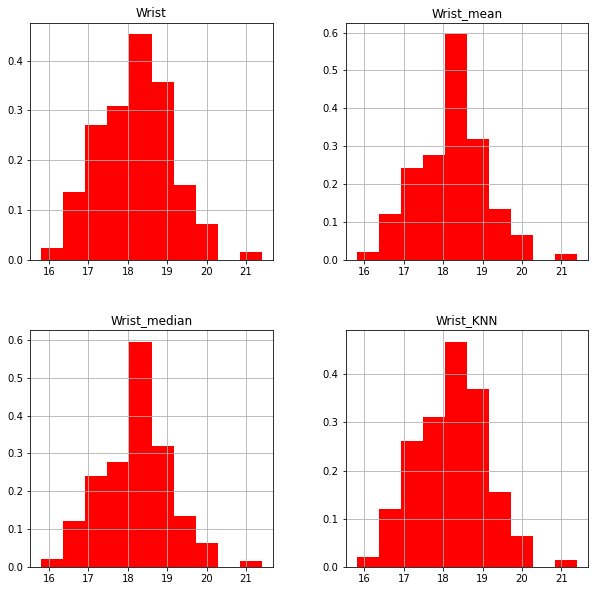

In [ ]:
replace_and_plot(data_new, "Wrist")